<div align="center" dir="auto">
<p dir="auto">

<a href="https://colab.research.google.com/github/write-with-neurl/modelbit-articles/blob/main/modelbit-07/Deploying_OpenAI_Whisper_with_ModelBit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

</p>

# ⚡ Deploying Open AI’s Whisper Models as REST Endpoints With ModelBit



Before deploying, it's always good practice to test things locally! In this section, we'll focus on writing a simple function to call [Whisper](https://github.com/openai/whisper)'s `transcribe()` function.

## 🏠 Testing Locally

### 🧑‍💻 Installations and Set Up



Install libraries you will use to build and test Whisper.

In [1]:
# Install ffmpeg, required by Whisper for audio input.
!apt-get update && apt-get install ffmpeg

# Using latest version of pip
!pip install --upgrade pip

# Quietly install the latest version of 'modelbit' and `openai-whisper`
# for our model deployment demo
!pip install -q --upgrade modelbit openai-whisper

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [624 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,010 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,404 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,203 kB]
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:13 https://p

In [2]:
# Check lib version
!pip3 show openai-whisper

Name: openai-whisper
Version: 20231106
Summary: Robust Speech Recognition via Large-Scale Weak Supervision
Home-page: https://github.com/openai/whisper
Author: OpenAI
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: more-itertools, numba, numpy, tiktoken, torch, tqdm, triton
Required-by: 


### 🔃 Download and Load Whisper Weights into Memory



Import the necessary dependencies required to run the demo. Then, load the WhisperV2 weights. Depending on how much VRAM you have, choose the size of your weights carefully.

For free Colab notebooks, you can utilize the T4 GPUs which provide 16gb of VRAM. This means you should be able to load weights in that belong to the `large` class. You can change your runtime context on the top right corner of Colab.
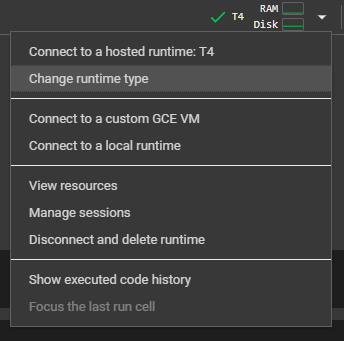

* To determine the size of weights you can load into Whisper, view this table [here](https://github.com/openai/whisper/tree/main#available-models-and-languages).

* To view the current names of each class size, click [here](https://github.com/openai/whisper/blob/main/whisper/__init__.py#L34).

In [3]:
import whisper
import requests
from tempfile import NamedTemporaryFile

# Load the Whisper model:
model = whisper.load_model('small')

100%|███████████████████████████████████████| 461M/461M [00:06<00:00, 78.3MiB/s]


### 🧪 Test Whisper Locally with a Sample Audio File



Now that you have loaded the Whisper weights, we can call `model.transcribe()` with a file path to an audio file on your local system or Colab file directory. To do this, simply use the `wget` or your preferred method to download or record an audio file.

In [4]:
!wget -O audio.mp3 http://www.moviesoundclips.net/movies1/grinch/merrychristmas.mp3

--2023-11-16 15:21:41--  http://www.moviesoundclips.net/movies1/grinch/merrychristmas.mp3
Resolving www.moviesoundclips.net (www.moviesoundclips.net)... 198.54.115.219
Connecting to www.moviesoundclips.net (www.moviesoundclips.net)|198.54.115.219|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44744 (44K) [audio/mpeg]
Saving to: ‘audio.mp3’

audio.mp3           100%[===================>]  43.70K  --.-KB/s    in 0.08s   

2023-11-16 15:21:41 (521 KB/s) - ‘audio.mp3’ saved [44744/44744]



Next, you’ll want to call `model.transcribe()` and print out the transcription results.

In [5]:
result = model.transcribe("/content/audio.mp3")
print(result["text"])

 Merry Christmas one and all!


### ✅Prepare a Whisper Transcription Function



Before we upload our working code to Modelbit, we need to wrap the transcription function in a function that will parse the inputs from our REST API endpoint. For our example, we can define a function that facilitates the transcription of online `.mp3` files. Below, we define a function aptly named `whisper_transcribe()`. We have designed this function to accept a URL, called `file`, as a string. This URL points to the audio file we want to transcribe.

The `whisper_transcribe()` function temporarily downloads the file from the URL. This downloaded file is then passed into `model.transcribe()` function. This function prompts Whisper to do what it does best: transcribe speech into actionable textual data.

Once the transcription process finishes, the function returns a JSON object with the results.


In [6]:
def whisper_transcribe(file):
    # Download the file data
    response = requests.get(file)

    # Just ensure that the download was successful
    response.raise_for_status()

    with NamedTemporaryFile() as temp:
        # Write the downloaded data to the temporary file
        temp.write(response.content)
        temp.flush()

        # Let's get the transcript of the temporary file.
        transcript = model.transcribe(temp.name)

        return { 'transcript': transcript['text'] }


Finally, we're ready to use our function locally. Simply pass in a URL into `inference()`.

Feel free to experiment with different audio snippets by visiting this site [here](http://www.moviesoundclips.net), right clicking on the audio player, and clicking `Copy Audio Address...`. Then, pass this URL into the function.

In [7]:
whisper_transcribe('http://www.moviesoundclips.net/movies1/grinch/merrychristmas.mp3')

{'transcript': ' Merry Christmas one and all!'}

## 🚀 Deploying Whisper to a REST API Endpoint



Now that we've verified it works locally, it's time to see how easy it is to take our code and deploy directly to Modelbit with minimal lines of code.

### 🔐 Log into `modelbit`



Use the [`modelbit`](https://doc.modelbit.com/deployments/) library for model deployment and management. Modelbit offers you a flexible approach to [deploy ML models](https://www.modelbit.com/product/deploy-from-anywhere) from your Colab or Jupyter notebooks, or any Python environment, to production environments with REST APIs. With fully custom Python environments. Backed by your git repo.

In [8]:
import modelbit

# Log into the 'modelbit' service using the development ("dev") branch
# Ensure you create a "dev" branch in Modelbit or use the "main" branch for your deployment
mb = modelbit.login(branch="dev")

### 📦 Deploying to Modelbit


Calling the `mb.deploy()` API will run the following for you under-the-hood:

- **Push** the source code to your Modelbit workspace.

- **Pickle the variables in the dev environment**: Your function's variables are pickled, i.e., serialized into a format that can be stored and reconstructed.

- **Detect the dependencies:** Unlike traditional deployment strategies that require manual tracking of dependencies, ModelBit intelligently detects which dependencies, libraries, and data your application needs.

- **Containerize the model weights and other helper files:** It then automatically incorporates these into the container it builds, significantly reducing the possibility of errors and saving deployment time.

- **Spin up a REST API endpoint**: After containerizing your model and it’s dependencies, Modelbit replicates the environment in production for consistency and spins up a REST endpoint.

In the event [`mb.deploy()`](https://doc.modelbit.com/api-reference/deploy/) misses any packages, you there are additional flags you can pass, such as shown below:

```python
mb.deploy(inference,
          python_packages=["git+https://github.com/some-project/project.git.git",
                           "numpy==1.23.5",
                           "torch"
                          ],
          system_packages=["ffmpeg"]
          )
```

In our deployment below, we also want to deploy to Modelbit with a GPU on the inference server. This can either be enabled on Modelbit's dashboard or within `mb.deploy()` at any time.

For more information regarding environment customization, click [here](https://doc.modelbit.com/deployments/custom-python-environments/).

In [9]:
mb.deploy(whisper_transcribe, require_gpu=True, system_packages=["ffmpeg"])

Uploading 'model': 100%|██████████| 571M/571M [00:07<00:00, 72.6MB/s]


## 📩 Test the REST Endpoint with an MP3 URL

Test your endpoint from the command line using:

> ⚠️ Replace the `ENTER_WORKSPACE_NAME` placeholder with your workspace name.

In [10]:
!curl -X POST "https://ENTER_WORKSPACE_NAME.app.modelbit.com/v1/whisper_transcribe/dev/latest" -d '{"data": "http://www.moviesoundclips.net/movies1/grinch/merrychristmas.mp3"}'

{"data":{"transcript":" Merry Christmas one and all!"}}

You can also test your REST Endpoint by [sending single or batch requests](https://doc.modelbit.com/deployments/rest-api/single-inference) to it for transcription.

Use the `requests` package to POST a request to the API and use `json` to format the response to print nicely:


> ⚠️ Replace the `ENTER_WORKSPACE_NAME` placeholder with your workspace name.

In [11]:
import json

requests.post("https://ENTER_WORKSPACE_NAME.app.modelbit.com/v1/whisper_transcribe/dev/latest",
              headers={"Content-Type":"application/json"},
              data=json.dumps({"data": "http://www.moviesoundclips.net/movies1/grinch/merrychristmas.mp3"})).json()


{'data': {'transcript': ' Merry Christmas one and all!'}}

# 📚 Modelbit Machine Learning Blog

Enjoyed this walkthrough? Check out articles with similar walkthroughs:

- [Deploying a BERT Model to a REST API Endpoint for Text Classification](https://www.modelbit.com/blog/deploying-a-bert-model-to-a-rest-api-endpoint-for-text-classification)

- [Deploying a Grounding DINO Model to a REST API Endpoint for Open-Set Object Detection with Prompts](https://www.modelbit.com/blog/deploying-grounding-dino-model-to-a-rest-api-endpoint-for-open-set-object-detection-with-prompts)

- [Deploying a Segment-Anything Image Recognition Model to a REST Endpoint](https://www.modelbit.com/blog/deploying-a-segment-anything-image-recognition-model-to-a-rest-endpoint)